# Create S2 L1C Sample Data

Developing in the domain of earth observation we sometimes need a small dataset to play around, add as data sample to some code or package we shapre or to use for testing our code.   
This notebook shows how to clip a small window from a Sentinel-2 (S2) Level-1C (i.e. top-of-atmosphere reflectance).

A S2 L1C (*S2A_MSIL1C_20170216T102101_N0204_R065_T33UUU_20170216T102204.SAFE*) scene downloaded from the [Copernicus Open Access Hub](https://scihub.copernicus.eu/) comes as several individual JPEG2000 raster files which have different resolution. 
In this notebook we clip and save a small window from these layers by keeping the resolution intact. 
The data created here is contained as sample and test dataset *s2l1c* in the **eo-box** package.

Let's first import the packages we need:

In [2]:
from affine import Affine
import glob
import matplotlib.pyplot as plt
import os
import pandas as pd
import rasterio
from rasterio.windows import Window
import seaborn as sns

% matplotlib inline

Now we need the layer files and some information from the full-tile S2 L1C scene.

In [5]:
scene_dir = r'xxx_uncontrolled/S2A_MSIL1C_20170216T102101_N0204_R065_T33UUU_20170216T102204.SAFE'
layer_files = glob.glob(f'{scene_dir}/**/*_[B]??.jp2', recursive=True)
parts = [os.path.basename(file).split(".")[0].split("_") for file in layer_files]
layers_df = pd.DataFrame(parts, columns=["tile", "datetime", "band"])
layers_df["file"] = layer_files
layers_df = layers_df.set_index("band").sort_index()
layers_df

,tile,datetime,file
band,,,
B01,T33UUU,20170216T102101,xxx_uncontrolled/S2A_MSIL1C_20170216T102101_N0...
B02,T33UUU,20170216T102101,xxx_uncontrolled/S2A_MSIL1C_20170216T102101_N0...
B03,T33UUU,20170216T102101,xxx_uncontrolled/S2A_MSIL1C_20170216T102101_N0...
B04,T33UUU,20170216T102101,xxx_uncontrolled/S2A_MSIL1C_20170216T102101_N0...
B05,T33UUU,20170216T102101,xxx_uncontrolled/S2A_MSIL1C_20170216T102101_N0...
B06,T33UUU,20170216T102101,xxx_uncontrolled/S2A_MSIL1C_20170216T102101_N0...
B07,T33UUU,20170216T102101,xxx_uncontrolled/S2A_MSIL1C_20170216T102101_N0...
B08,T33UUU,20170216T102101,xxx_uncontrolled/S2A_MSIL1C_20170216T102101_N0...
B09,T33UUU,20170216T102101,xxx_uncontrolled/S2A_MSIL1C_20170216T102101_N0...


We want to clip the same small spatial area from all layers. 
Let's get the window from one of the 60m layers.

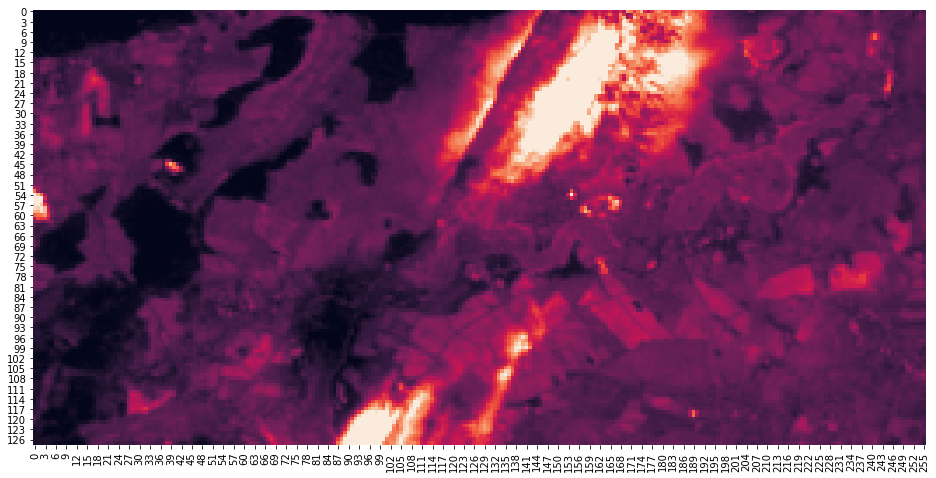

In [6]:
win_60m = Window(col_off=500, row_off=1300, width=2**8, height=2**7)
with rasterio.open(layers_df.at["B01", "file"]) as src:
    meta_60m = src.meta
    arr_60m = src.read(1, window=win_60m)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.heatmap(arr_60m, robust=True, cbar=False)

Since the layers have all different resolution / cell size, we need to derive the corresponding windows for the other layer. 
This is implemented in the follwoing function.

In [7]:
def transform_window(window_src, transform_src, transform_dst):
    spatial_bounds = rasterio.windows.bounds(window=window_src, transform=transform_src,
                                             height=0, width=0)  # defaults
    window_dst = rasterio.windows.from_bounds(spatial_bounds[0], 
                                              spatial_bounds[1], 
                                              spatial_bounds[2],
                                              spatial_bounds[3], 
                                              transform=transform_dst, 
                                              height=None, width=None, precision=None)  # defaults
    return window_dst

Visually and with respect to the window relations the function seems to do what it should.

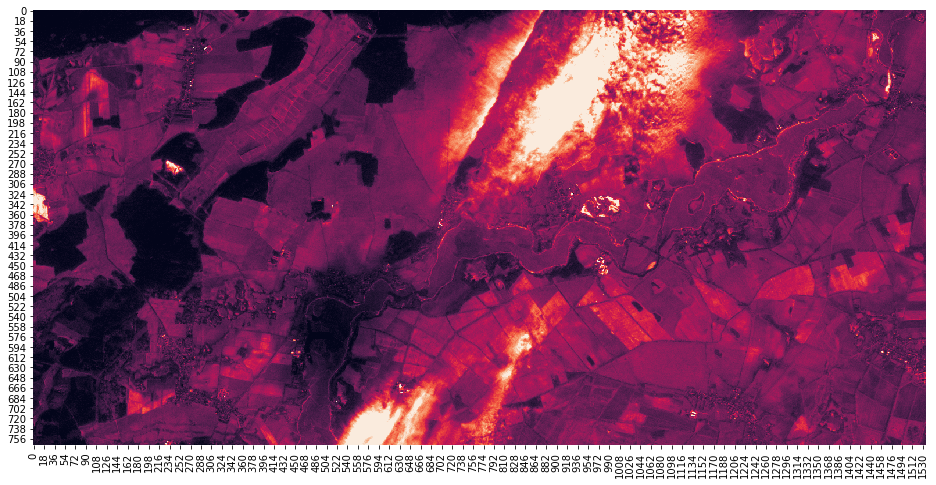

In [8]:
with rasterio.open(layers_df.at["B02", "file"]) as src:
    meta_10m = src.meta
    win_10m = transform_window(window_src=win_60m, 
                               transform_src=meta_60m["transform"],
                               transform_dst=meta_10m["transform"])
    arr_10m = src.read(1, window=win_10m)
    
assert(win_10m.height == win_60m.height * 6)
assert(win_10m.width == win_60m.width * 6)
assert(win_10m.row_off == win_60m.row_off * 6)
assert(win_10m.col_off == win_60m.col_off* 6)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.heatmap(arr_10m, robust=True, cbar=False)

Now we can loop through all the layers and save the subset.
The destination files of the subsetted files are printed out.

In [13]:
dst_dir = r'xxx_uncontrolled/s2l1c'
# from the 60 m
win = Window(col_off=500, row_off=1300, width=2**8, height=2**7)
transform = Affine(60.0, 0.0, 300000.0, 0.0, -60.0, 5900040.0)
blockxsize = blockysize = 2**6

for filename_src in layers_df["file"].values:
    filename_dst = os.path.join(dst_dir, *filename_src.split("/")[-2:])
    bprint(filename_dst)
    if not os.path.exists(os.path.dirname(filename_dst)):
        os.makedirs(os.path.dirname(filename_dst))
    if not os.path.exists(filename_dst):
        with rasterio.open(filename_src) as src:
            win_this = transform_window(window_src=win, 
                                        transform_src=transform,
                                        transform_dst=src.meta["transform"])
            arr = src.read(window=win_this)
            kwargs = src.meta.copy()
            kwargs.update({
                'height': win_this.height,
                'width': win_this.width,
                'transform': rasterio.windows.transform(win_this, src.transform),
                'compress': "JPEG2000"})
            with rasterio.open(filename_dst, 'w', **kwargs, 
                               tiled=True, blockxsize=blockxsize, blockysize=blockysize) as dst:
                dst.write(arr)

xxx_uncontrolled/s2l1c/IMG_DATA/T33UUU_20170216T102101_B01.jp2
xxx_uncontrolled/s2l1c/IMG_DATA/T33UUU_20170216T102101_B02.jp2
xxx_uncontrolled/s2l1c/IMG_DATA/T33UUU_20170216T102101_B03.jp2
xxx_uncontrolled/s2l1c/IMG_DATA/T33UUU_20170216T102101_B04.jp2
xxx_uncontrolled/s2l1c/IMG_DATA/T33UUU_20170216T102101_B05.jp2
xxx_uncontrolled/s2l1c/IMG_DATA/T33UUU_20170216T102101_B06.jp2
xxx_uncontrolled/s2l1c/IMG_DATA/T33UUU_20170216T102101_B07.jp2
xxx_uncontrolled/s2l1c/IMG_DATA/T33UUU_20170216T102101_B08.jp2
xxx_uncontrolled/s2l1c/IMG_DATA/T33UUU_20170216T102101_B09.jp2
xxx_uncontrolled/s2l1c/IMG_DATA/T33UUU_20170216T102101_B10.jp2
xxx_uncontrolled/s2l1c/IMG_DATA/T33UUU_20170216T102101_B11.jp2
xxx_uncontrolled/s2l1c/IMG_DATA/T33UUU_20170216T102101_B12.jp2
xxx_uncontrolled/s2l1c/IMG_DATA/T33UUU_20170216T102101_B8A.jp2


**The End.**